In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import numpy as np
import pandas as pd
import torch_geometric as pyg
import hydra
from hydra.core.global_hydra import GlobalHydra
import os
os.environ["HYDRA_FULL_ERROR"] = "1"


from mil.data.mnist import MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, detach, human_format
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.utils.layers import Aggregate, Select, SqueezeUnsqueeze
from mil.models import MILModel
from mil.models.gnn import GNN
from mil.models.positional_encoding import FourierPositionalEncodingLayer, AxialPositionalEncodingLayer
from mil.models.abmil import WeightedAverageAttention
from mil.models.self_attention import MultiHeadSelfAttention
from mil.models.set_transformer import SetTransformer, InducedSetTransformer, SAB, ISAB
from mil.models.distance_aware_self_attention import DistanceAwareSelfAttentionHead

RESULTS_FILE = "train.csv"

GlobalHydra().clear()
hydra.initialize(config_path="conf")
cfg = hydra.compose("config.yaml", overrides=["+experiment=mnist_collage", "+model=distance_aware_self_attention"])

/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/75/85q4yvfd39z3s95j568dmh640000gn/T/ipykernel_39631/1352042474.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="conf")


# MNIST bags / MNIST collage

This notebook trains models on variations of the *mnist-bags*, *multi-mnist-bags*, and *mnist-collage* datasets. 
The goal of this notebook is to see which models are able to overfit on these datasets.


The following cell defines three variables, `DATASET`, `TARGET_NUMBERS` and `MODEL` which can be used to run different dataset/model configurations.

`DATASET`:
- `OneHotMNISTBags`: one-hot version of *mnist-bags*, where the dataset yields 10-dimensional one-hot encoded feature vectors directly (i.e. we are not yet working with MNIST digits)
- `MNISTBags`: the *mnist-bags* dataset
- `OneHotMNISTCollage`: one-hot version of *mnist-collage*
- `MNISTCollage`: *mnist-collage* dataset

`TARGET_NUMBERS`:
- `0` corresponds to the *mnist-bags* dataset
- `(0, 1)` corresponds to the *multi-mnist-bags* dataset

`MODELS`:
- `"mean_pool"`: simple baseline that uses mean pooling. Works neither dataset.
- `"max_pool"`: simple baseline that uses max pooling. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"weighted_average_attention"`: uses attention mechanism from "Attention Based Deep Multiple Instance Learning" paper which can only "focus" on one target number at a time. Works for *mnist-bags*, but not *multi-mnist-bags*.
- `"self_attention_mean_pooling"`: uses a single transformer layer (self attention) followed by mean pooling. Works for both datasets.
- `"self_attention_max_pooling"`: uses a single transformer layer (self attention) followed by max pooling. Works for both datasets (but better than mean pooling).


Try changing `DATASET`, `TARGET_NUMBERS` and `MODELS` below and rerunning the notebook.

In [2]:
datasets = {
    "train": hydra.utils.instantiate(cfg.dataset.train),
    "test": hydra.utils.instantiate(cfg.dataset.test)
}

def make_data_loader(train: bool = True):
    """Utility function to create a data loader for the dataset."""
    ds = datasets["train" if train else "test"]
    return torch.utils.data.DataLoader(ds, batch_size=1, shuffle=train, collate_fn=lambda x: x[0])

## Define the model

The three parts of the MIL model are:
1. **feature extractor**: extract a feature vector $z \in \mathbb{R}^D$ from each instance. In the case of the one-hot dataset, this is just the identity function. For the actual *mnist-bags* dataset, this is a CNN.
2. **pooling**: a function $f : \mathbb{R}^{N \times D} \to \mathbb{R}^D$ that aggregates the $N$ feature vectors in the bag to a single feature vector.
3. **classifier**: a function $g : \mathbb{R}^D \to \mathbb{R}$ that transforms the aggregated feature vector into a binary classification prediction (we parameterise $g$ using a linear layer followed by a sigmoid)


In [3]:
model = hydra.utils.instantiate(cfg.model, _convert_="partial")

## Define loss function and optimizer

We use binary cross-entropy loss.

In [4]:
loss_function = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

def error_score(y_pred, y):
    return 1. - ((y_pred > .5).float() == y).cpu().detach().float()

Helper code to evaluate on test set:

In [5]:
test_loader = make_data_loader(train=False)

def test_loss_and_error(model, loader):
    model.eval()

    total_loss = 0.
    total_error = 0.
    predictions = []

    with torch.no_grad():
        for i, bag in enumerate(loader):
            bag = device(bag)
            y = bag.y.float()

            # Calculate loss and metrics
            y_pred = model(bag.x, bag.edge_index, bag.edge_attr).squeeze()
            loss = loss_function(y_pred, y)

            predictions.append((bag.cpu().detach(), y_pred.detach().cpu()))

            error = error_score(y_pred, y)
            total_error += error
            total_loss += loss.detach().cpu()
    return total_loss / len(loader), total_error / len(loader), predictions

## Train

In [6]:
loader = make_data_loader(train=True)

stats = []

model.train()
print(f"Training model with {human_format(sum(p.numel() for p in model.parameters() if p.requires_grad))} parameters")

for epoch in range(50):
    model.train()

    total_loss = 0.
    total_error = 0.
    for bag in loader:
        bag = device(bag)
        y = bag.y

        optimizer.zero_grad()

        # Calculate loss and metrics
        y_pred = model(bag.x, bag.edge_index, bag.edge_attr).squeeze()
        loss = loss_function(y_pred, y)

        error = error_score(y_pred, y)
        total_error += error
        
        # Backward pass
        loss.backward()

        total_loss += loss.detach().cpu()
        # Step
        optimizer.step()
    
    test_loss, test_error, _ = test_loss_and_error(model, test_loader)

    stats.append({
        "epoch": epoch,
        "loss": total_loss / len(loader),
        "error": total_error / len(loader),
        "test_loss": test_loss,
        "test_error": test_error
    })
    print(
        f"Epoch: {epoch:3d}, loss: {total_loss/len(loader):.4f}, error: {total_error/len(loader):.4f}, test_loss: {test_loss:.4f}, test_error: {test_error:.4f}")

# Plot training and test loss/error
stats = pd.DataFrame(stats)
float_cols = [col for col in stats.columns if col != "epoch"]
stats[float_cols] = stats[float_cols].astype(float)
stats.to_csv(RESULTS_FILE, index=False)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Loss")
plt.plot(stats["epoch"], stats["loss"], label="train")
plt.plot(stats["epoch"], stats["test_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.title("Error")
plt.plot(stats["epoch"], stats["error"], label="train")
plt.plot(stats["epoch"], stats["test_error"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

Training model with 17.4K parameters


/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch:   0, loss: 0.7044, error: 0.5033, test_loss: 0.6915, test_error: 0.4700
Epoch:   1, loss: 0.6986, error: 0.4833, test_loss: 0.6857, test_error: 0.4800
Epoch:   2, loss: 0.6852, error: 0.4633, test_loss: 0.6246, test_error: 0.2800
Epoch:   3, loss: 0.6366, error: 0.3267, test_loss: 0.5450, test_error: 0.2900
Epoch:   4, loss: 0.6385, error: 0.3300, test_loss: 0.4815, test_error: 0.1600
Epoch:   5, loss: 0.5328, error: 0.2767, test_loss: 0.4375, test_error: 0.1800
Epoch:   6, loss: 0.5509, error: 0.2633, test_loss: 0.4824, test_error: 0.1700
Epoch:   7, loss: 0.5325, error: 0.2567, test_loss: 0.4538, test_error: 0.2500


KeyboardInterrupt: 

## Test

In [7]:
test_loss, test_error, predictions = test_loss_and_error(model, test_loader)
print(f"Test loss: {test_loss:.4f}, test error: {test_error:.4f}")

print_prediction_stats(predictions, target_numbers=cfg.settings.mnist.target_numbers)

Test loss: 0.4212, test error: 0.1700
0 <class 'int'>
1 <class 'int'>
0 <class 'int'>
1 <class 'int'>
0 <class 'int'>
1 <class 'int'>

                                 % acc    total    -pred    +pred     example
  bags                              83      100       57       43     0 7 4 8 8 1 9 2 5
  bags with 0s                      78       78       35       43     0 7 4 8 8 1 9 2 5
  bags without 0s                  100       22       22        0     5 7 5 6 8 6 8 2 7 9
  bags with 0s and 1s               73       65       22       43     0 7 4 8 8 1 9 2 5
  bags with 0s and not 1s          100       13       13        0     9 3 2 5 3 3 4 5 0 6 0
  bags with 1s                      77       77       34       43     0 7 4 8 8 1 9 2 5
  bags without 1s                  100       23       23        0     5 7 5 6 8 6 8 2 7 9
  bags with 1s and 0s               73       65       22       43     0 7 4 8 8 1 9 2 5
  bags with 1s and not 0s          100       12       12        0     3 4 7

### First 10 bags in test dataset

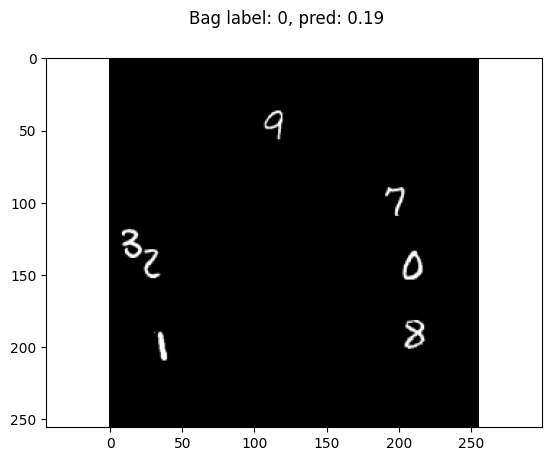

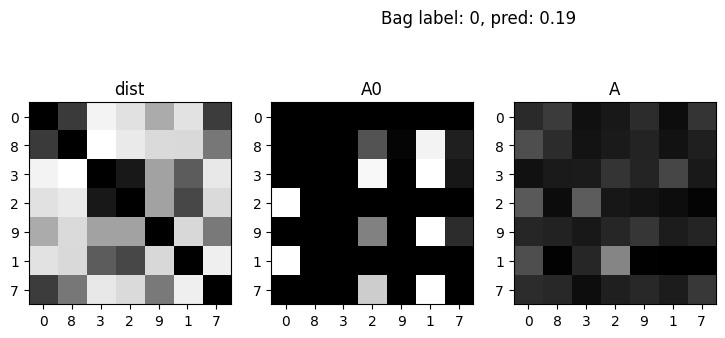

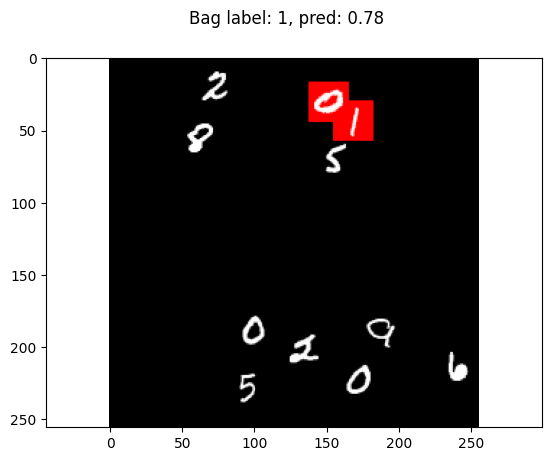

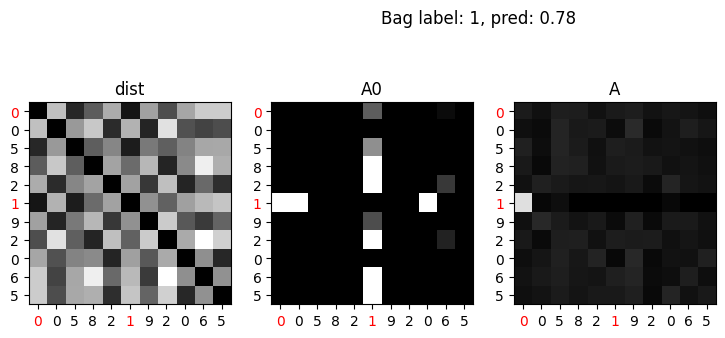

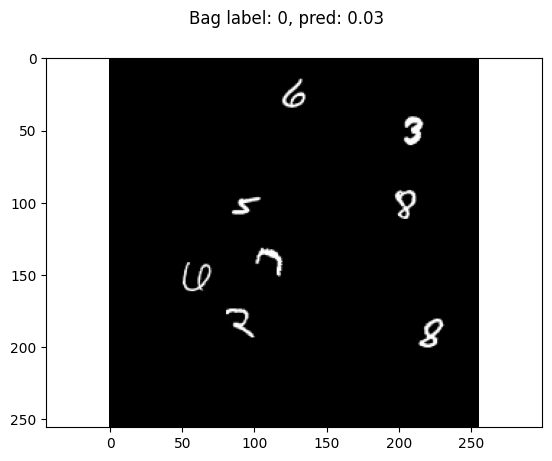

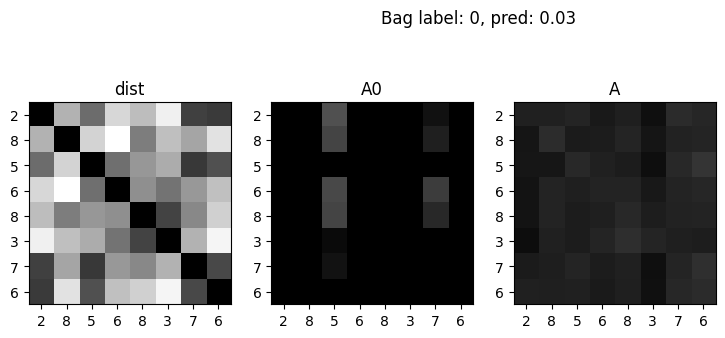

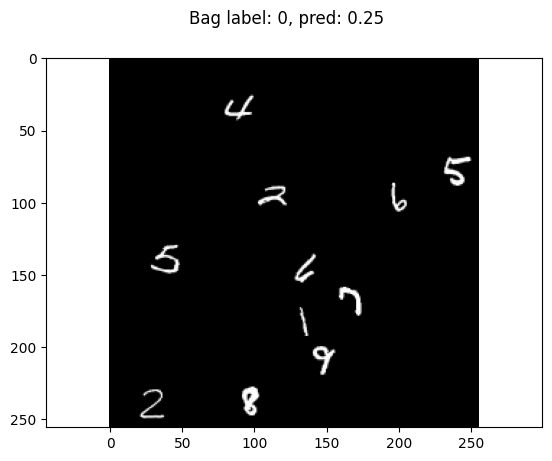

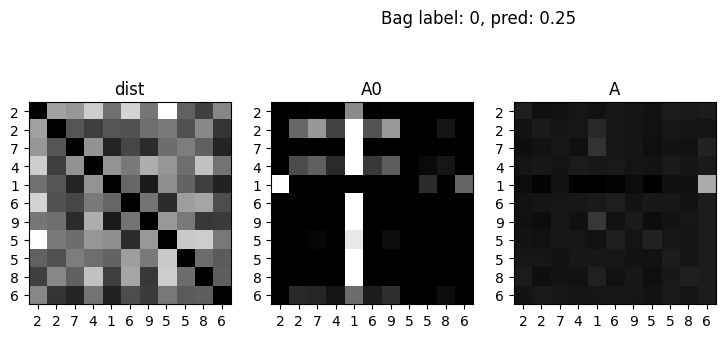

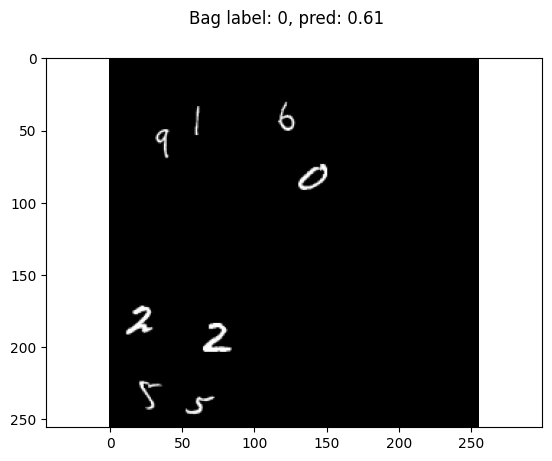

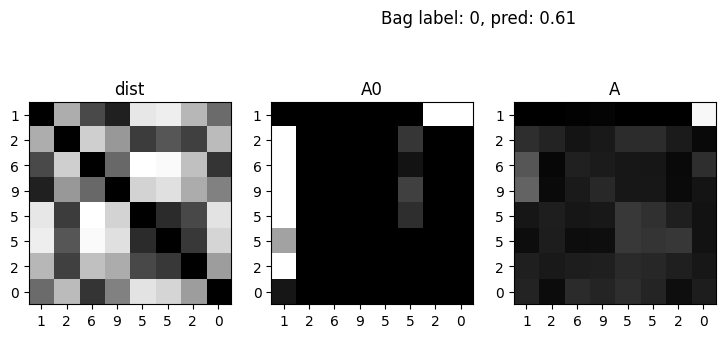

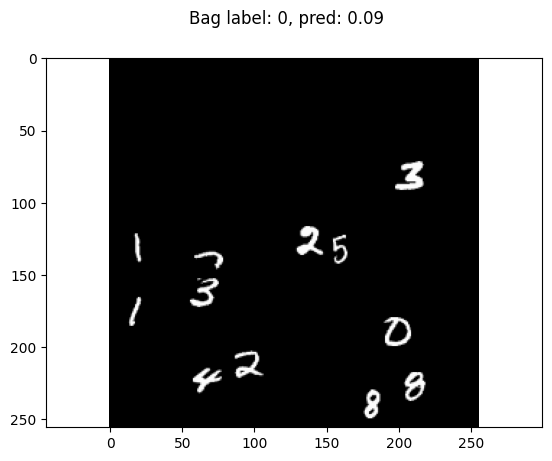

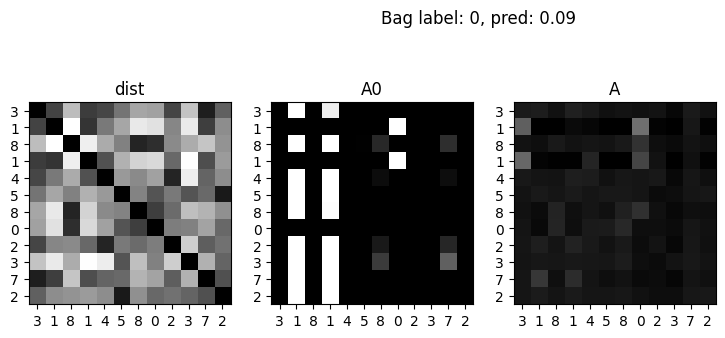

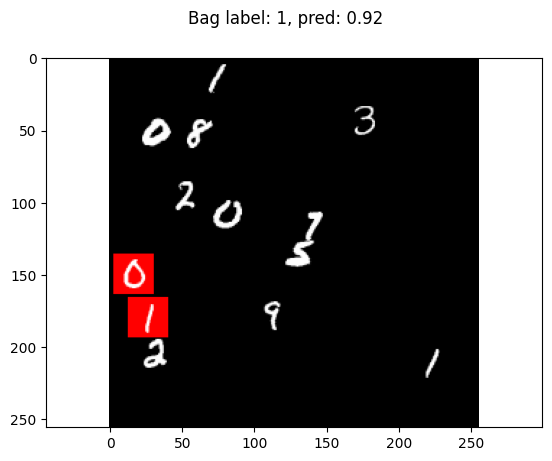

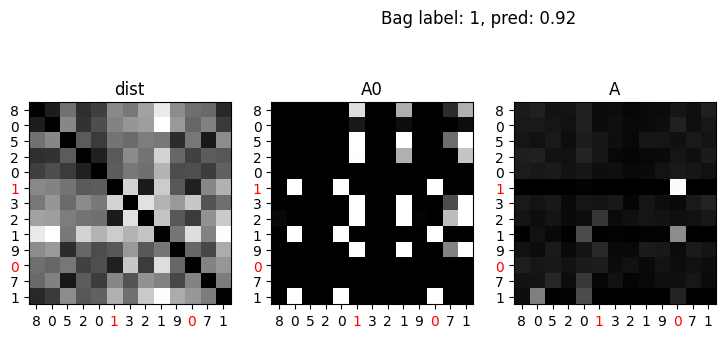

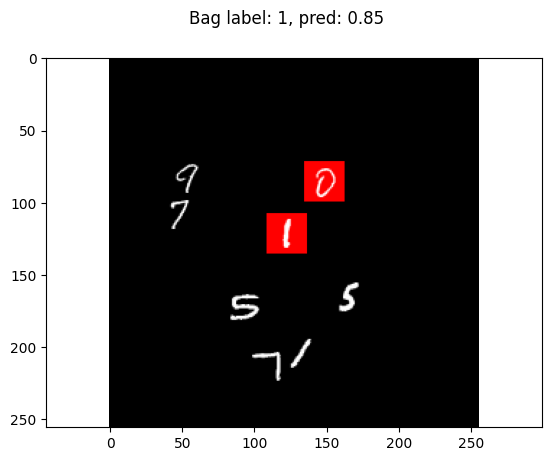

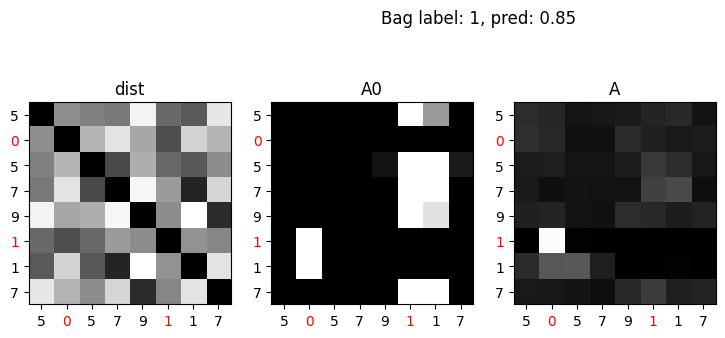

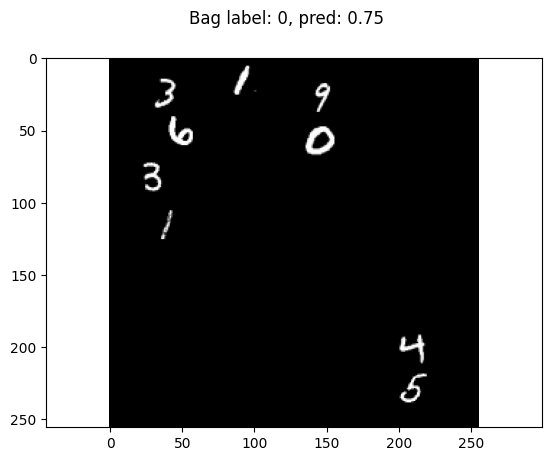

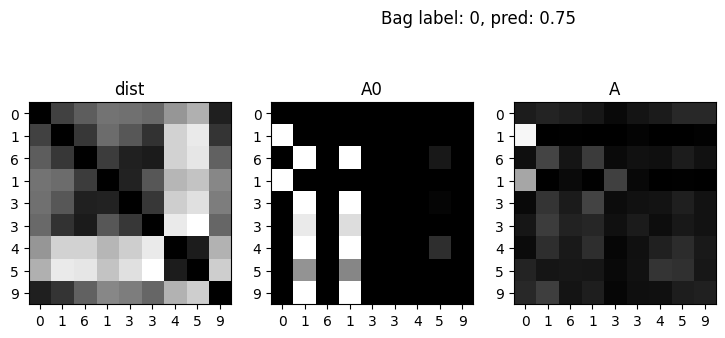

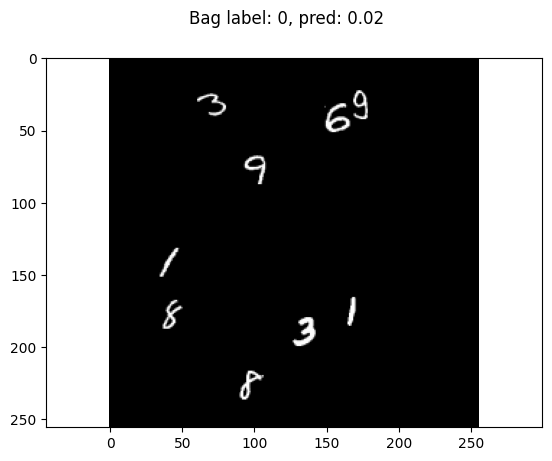

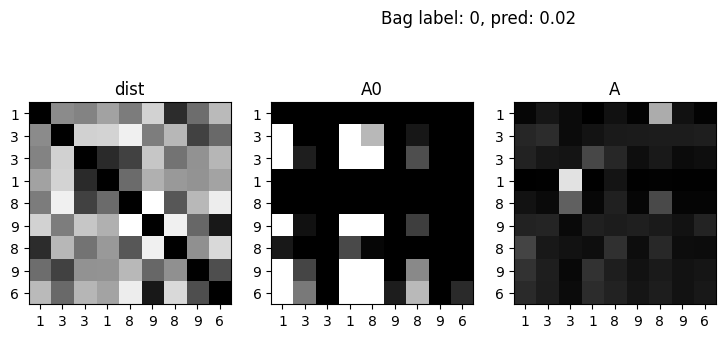

In [ ]:
def plot_dist_aware_attention(bag):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
    plt.subplot(141)
    plt.title("dist")
    data = attention_layer.data
    dist = pyg.utils.to_dense_adj(data.edge_index, edge_attr=data.edge_attr.squeeze(-1), max_num_nodes=data.num_nodes).squeeze(0)  # NxN
    plot_attention_head(bag, dist, limit_range=False)
    plt.subplot(142)
    plt.title("A0")
    plot_attention_head(bag, attention_layer.A0)
    plt.subplot(143)
    plt.title("A")
    plot_attention_head(bag, attention_layer.A)

def visualize_prediction(bag, y_pred):
    y = bag.y
    if DATASET == OneHotMNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            print_one_hot_bag_with_attention(bag, attention_layer.A, y_pred>.5)
            print()
        elif isinstance(attention_layer, MultiHeadAttention):
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            print_one_hot_bag(bag, y_pred>.5)
    elif DATASET == MNISTBags:
        if isinstance(attention_layer, WeightedAverageAttention):
            plot_bag(bag, y_pred=y_pred, attention=attention_layer.A.squeeze(-1))
        elif isinstance(attention_layer, MultiHeadAttention):
            plot_bag(bag, y_pred=y_pred)
            plt.figure()
            plot_attention_head(bag, attention_layer.A[0])
            plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        else:
            plot_bag(bag, y_pred=y_pred)
    elif DATASET == OneHotMNISTCollage:
        plt.figure()
        plot_one_hot_collage(bag, y_pred=y_pred)
        plt.title(f"Bag label: {y.item():.0f}, pred: {y_pred.item():.2f}")
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)
    elif DATASET == MNISTCollage:
        plot_bag(bag, y_pred=y_pred, collage_size=COLLAGE_SIZE)
        if isinstance(attention_layer, DistanceAwareSelfAttentionHead):
            plot_dist_aware_attention(bag)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.y.float()
        y_pred = model(bag).squeeze(0)
        visualize_prediction(bag, y_pred)

### First 10 mistakes in test dataset

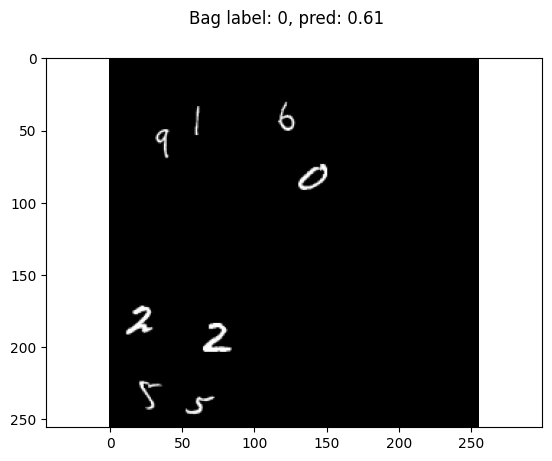

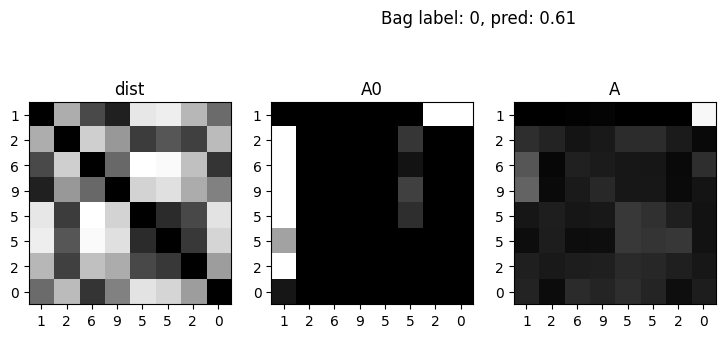

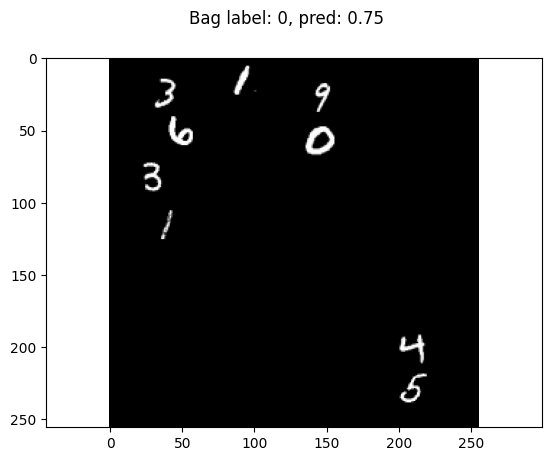

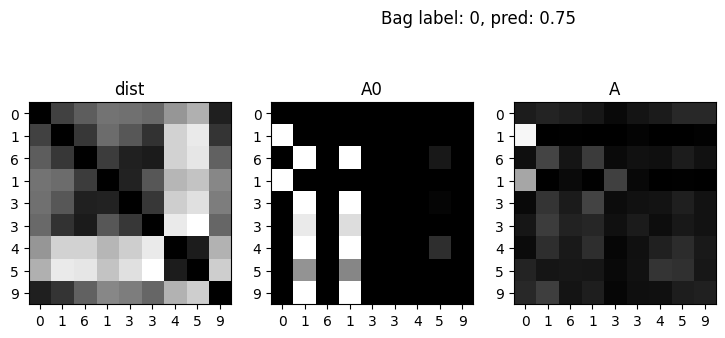

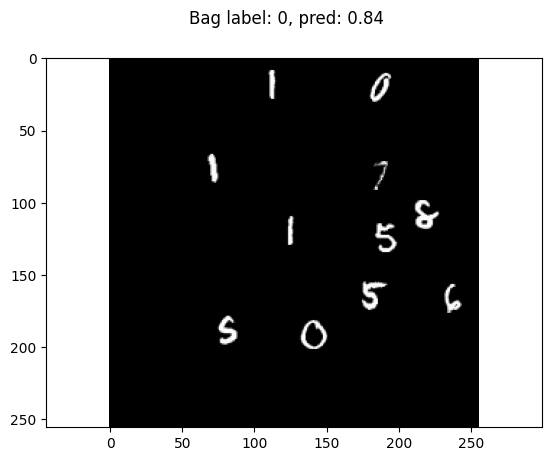

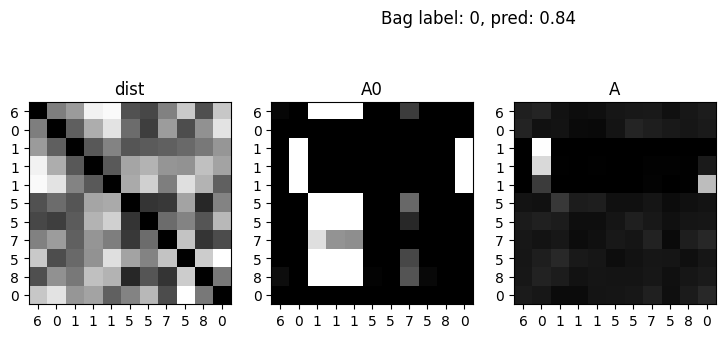

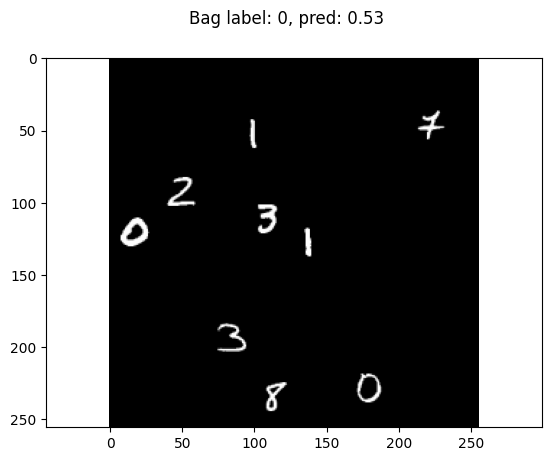

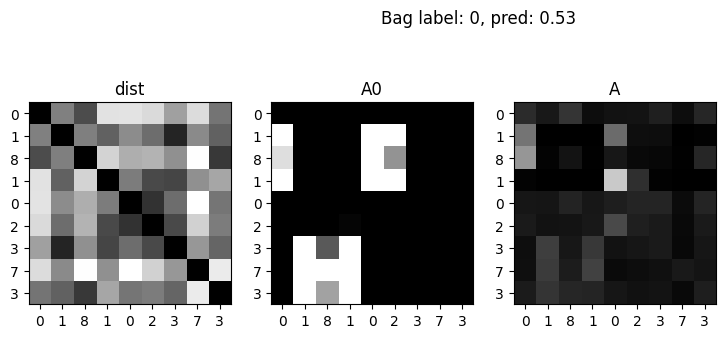

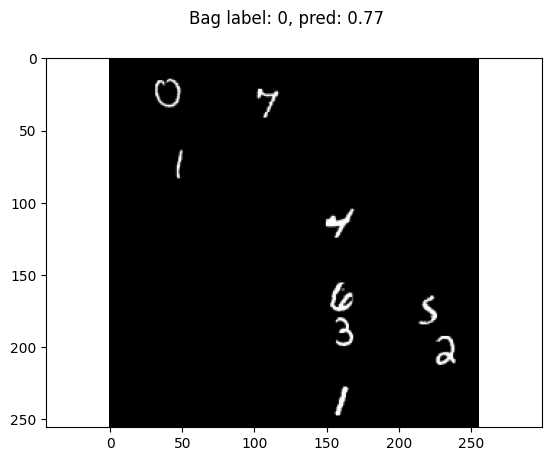

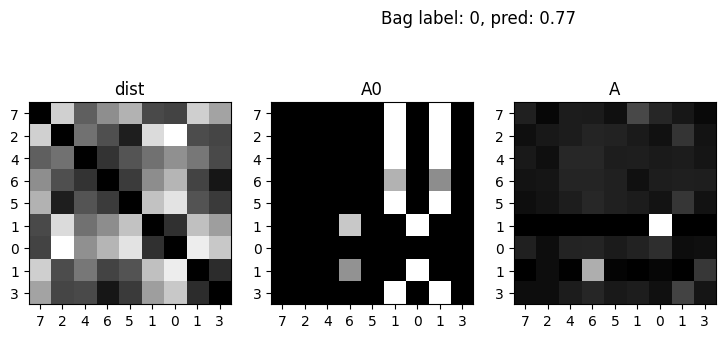

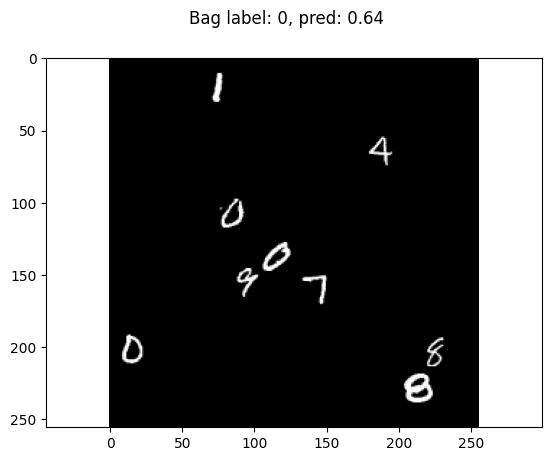

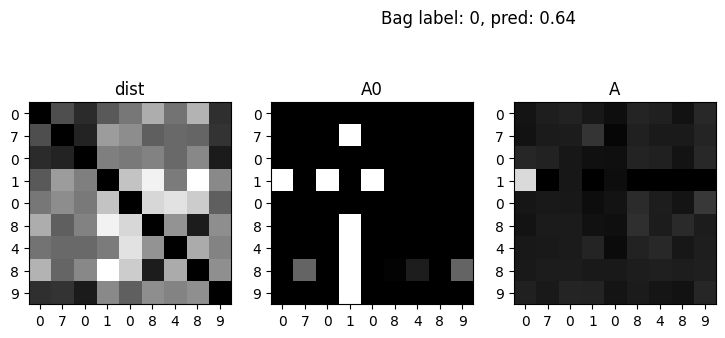

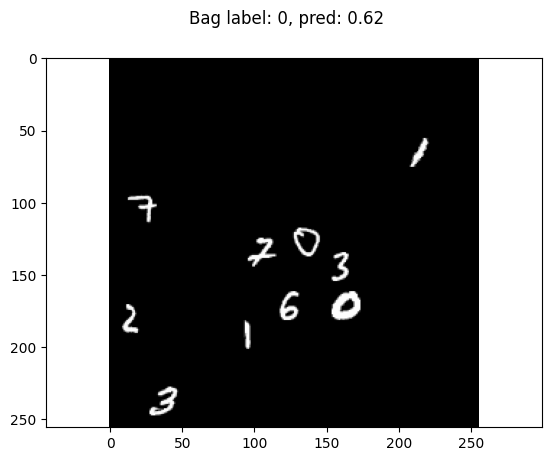

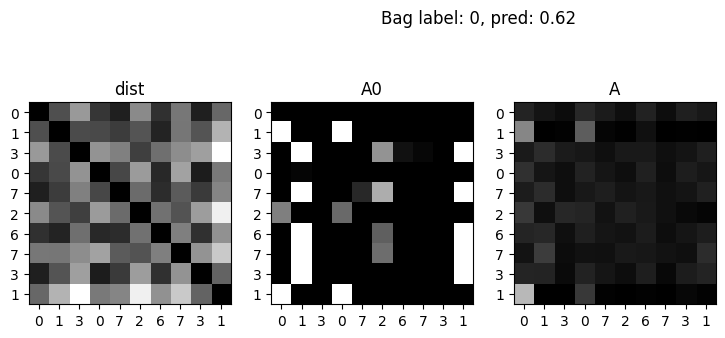

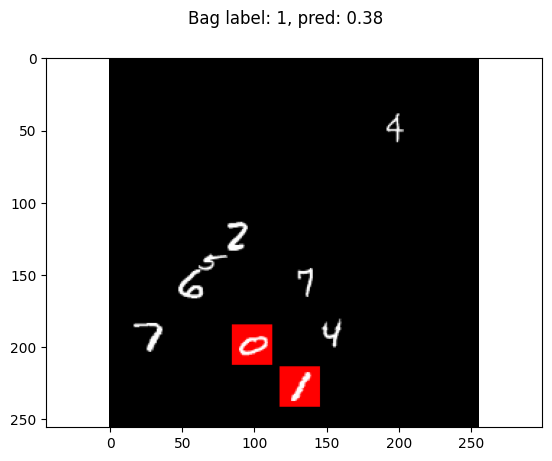

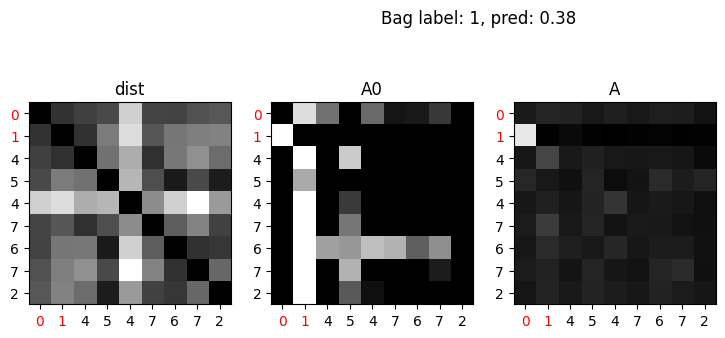

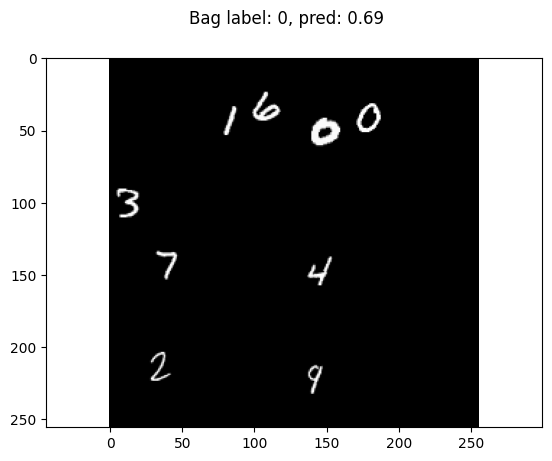

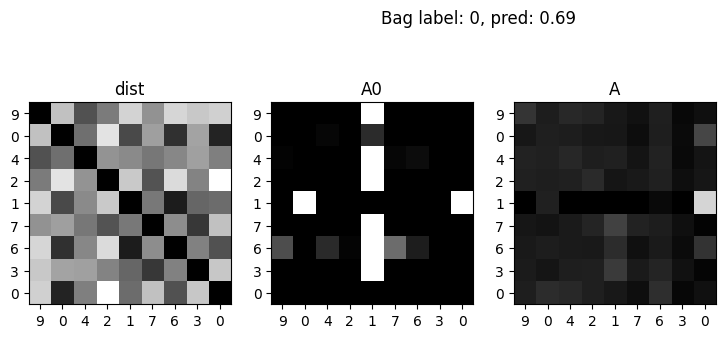

In [ ]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        bag = device(bag)
        y = bag.y.float()
        y_pred = model(bag).squeeze(0)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred)
            i += 1